# Training the RPN signature on multi-center data

- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/1_multi-center_training.ipynb

- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature

- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3

- Raw data from center 3 is available upon reasonable request.

### Imports

In [1]:
import sys
sys.path.append('../')
from PAINTeR import connectivity # in-house lib used for the RPN-signature
from PAINTeR import plot # in-house lib used for the RPN-signature
from PAINTeR import model # in-house lib used for the RPN-signature
import numpy as np # hi old friend
import pandas as pd

from sklearn.preprocessing import StandardScaler
from nilearn.connectome import ConnectivityMeasure

from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from sklearn.linear_model import ElasticNet, Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, KFold, GroupKFold, LeavePGroupsOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

from neurocombat_sklearn import CombatModel

import scipy.stats as stats
import joblib

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load and merge behavioral data for all three centers (after exclusions)

In [2]:
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
df

,index,Unnamed: 0,ID,Excluded,exclusion_crit,Male,day_menses,Age,height,weight,...,weight..kg.,psq_moderate,psq_minor,PSQ20,PSQI,MDT_log_geom,Pulse_MRI,Pulse_QST,BDI,PSQ20_essen
0,0,0,4,0.0,NaN,1.0,NaN,25.552361,175.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,6,0.0,NaN,1.0,NaN,33.453799,183.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,7,0.0,NaN,1.0,NaN,26.119097,186.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,8,0.0,NaN,1.0,NaN,25.445585,180.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,9,0.0,NaN,0.0,6.0,22.573580,176.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,14,14,22,0.0,NaN,1.0,NaN,24.000000,185.0,82.0,...,NaN,27.0,11.0,6.0,1.0,-1.259900,73.0,76.0,5.0,24.0
87,15,15,24,0.0,NaN,1.0,NaN,22.000000,183.0,83.0,...,NaN,28.0,16.0,9.0,1.0,-1.913513,85.0,86.0,0.0,25.0
88,16,16,25,0.0,NaN,1.0,NaN,22.000000,195.0,77.0,...,NaN,20.0,9.0,11.0,NaN,-1.581106,88.0,91.0,1.0,25.0
89,17,17,28,0.0,NaN,0.0,5.0,23.000000,162.0,59.0,...,NaN,34.0,18.0,43.0,2.0,-1.145363,78.0,89.0,7.0,37.0


## Load preprocessed and scrubbed timeseries data

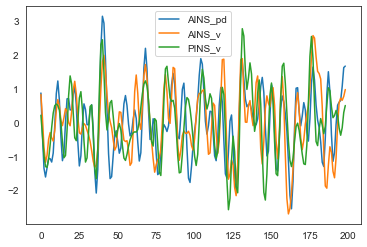

In [3]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'
    
    ts = pd.read_csv(f_scrub).iloc[:,1:] # here we can omit global signal...
    
    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd 
    
    perc_scrubbed.append(100 - 100*len(ts.shape)/len(fd) )
    timeseries.append(ts.values)
    
# double check visually
sub_idx=10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()

## Load region and module names for the MIST122 atlas

In [4]:
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

## Calculate functional connectivity as partial correlation

In [5]:
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
X = correlation_measure.fit_transform(timeseries) # these are the features

# double-check the mean matrix visually
mat=correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0 # zero diag
#plot.plot_matrix(mat, labels, modules)

## Create groups to balance the cross-validations across centers

In [6]:

plt.figure(figsize=(12, 0.3))
#sns.heatmap([df.study.astype("category").cat.codes.values]).set_title('study center')
#plt.show()
n_szeged = np.sum(df.study == 'szeged') # size of the smallest study
n_essen = np.sum(df.study == 'essen')
n_bochum = np.sum(df.study == 'bochum')
print(n_bochum, n_essen, n_szeged)

groups=np.zeros(len(df), dtype=int)

g=0
i=0
while i < n_bochum:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
    
g=0
i=n_bochum
while i < n_bochum+n_essen:
    groups[i] = g
    #groups[i+1] = g
    i += 1
    g += 1
g=0
i=n_bochum+n_essen
while i < len(df):
    groups[i] = g
    i += 1
    g += 1
    
plt.figure(figsize=(12, 0.3))
#sns.heatmap([groups]).set_title('groups')
#plt.show()

groups

35 37 19


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18])

<Figure size 864x21.6 with 0 Axes>

<Figure size 864x21.6 with 0 Axes>

## Pain sensitivity as target variable

In [7]:
y = df.mean_QST_pain_sensitivity

## Define model to be trained

In [18]:
# an oversimplified factory-function, defining the model to be trained:
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          p_grid={'fsel__k': [25, 50, 100, 1000, 3000],
                              'model__alpha': [.001, .005, .01, .05, .1, .5, 1, 5],
                              'model__l1_ratio': [0.0001, .25, .5, .75, 0.9999]         
                                   }):
                                      
    mymodel = Pipeline(
        [
         ('fsel', fsel),
         ('scaler', scaler),
         ('model', model)])
    return mymodel, p_grid

In [19]:
model, p_grid = pipe_scale_fsel_elnet()

## Do a non-nested, balanced cross validation, to optimize hyperparameters, then retain the final multi-center model

In [20]:
X_harmonized = CombatModel().fit_transform(X,
                                   np.array([df.study.astype("category").cat.codes.values]).transpose(),
                                   np.array([df.Male.values]).transpose(),
                                   np.array([df.Age.values]).transpose()
                                  )

cv = GroupKFold(30)
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)
clf.fit(X_harmonized, y, groups=groups)

cv_pred = cross_val_predict(clf.best_estimator_, X, y, cv=cv, groups=groups, n_jobs=-1)                                 

Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 49.3min finished


In [25]:
joblib.dump(X_harmonized, '../res/multi-center/harmonized_features.joblib')

['../res/multi-center/harmonized_features.joblib']

### Print out some non-nested accuracy estimates and plot the non-nested prediction (overly optimistic).

**** Non-nested analysis ****
** Best hyperparameters: {'fsel__k': 50, 'model__alpha': 0.05, 'model__l1_ratio': 0.9999}
** Score on full data as training set:	-0.07966890875374502
** Score on mean as model: -0.5655535039999882
** Best Non-nested cross-validated score on test:	-0.48994453408120336
XXXXX Explained Variance: 0.1336902156631079
Correlation: 0.5210497155635729


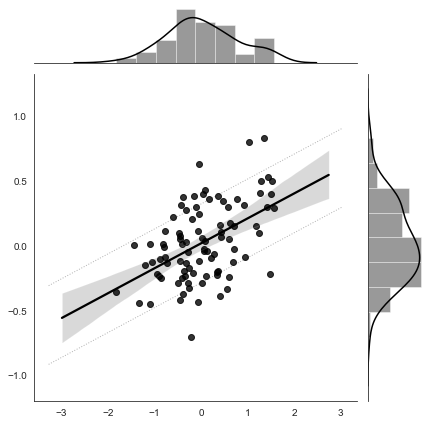

In [23]:
print("**** Non-nested analysis ****")
print("** Best hyperparameters: " + str(clf.best_params_))

print("** Score on full data as training set:\t" + str(-mean_squared_error(y_pred=clf.best_estimator_.predict(X), y_true=y)))
print("** Score on mean as model: " + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Best Non-nested cross-validated score on test:\t" + str(clf.best_score_))
print("XXXXX Explained Variance: " + str(
        1 - clf.best_score_ / -mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))

plot.plot_prediction(y.values, cv_pred, sd=True, covar=[])

In [24]:
joblib.dump(clf.best_estimator_, '../res/multi-center/finalized_model_combat_multi-center.joblib')
# save NON-nested cv-predictions
np.savetxt("../res/multi-center/nonnested_combat_cv_pred_full_GroupKFold30.csv", cv_pred, delimiter=",")

## Do a nested, balanced cross-validation, to obtain unbiased accuracy estimates

In [12]:
# we use the same model
model, p_grid = pipe_scale_fsel_elnet()

outer_cv = GroupKFold(30)
inner_cv = GroupKFold(30)                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y, groups=groups):
    group_train = groups[train]  
    
    comb = CombatModel()
    X_train_combat = comb.fit_transform(X[train],
                                   np.array([df.study.astype("category").cat.codes.values[train]]).transpose(),
                                   np.array([df.Male.values[train]]).transpose(),
                                   np.array([df.Age.values[train]]).transpose()
                                  )
    
    clf.fit(X[train], y[train], groups=group_train)
    
    X_test_combat = comb.transform(X[test],
                                   np.array([df.study.astype("category").cat.codes.values[test]]).transpose(),
                                   np.array([df.Male.values[test]]).transpose(),
                                   np.array([df.Age.values[test]]).transpose()
                                  )
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_test_combat)
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat, y[test])
    i = i+1

model	inner_cv mean score	outer vc score
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 1542 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 2942 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 3942 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4492 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 5142 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 5892 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 31.0min finished


cv: 0 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.35616853854669156 -0.32193542406520037
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 3982 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4532 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 5182 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 5932 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 27.3min finished


cv: 1 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.36859294736190035 -0.0405844396953369
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 3981 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4531 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 5181 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 5931 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 17.5min finished


cv: 2 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.38311546567314564 -0.18900226950443275
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1936 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 3919 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4280 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4741 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 5302 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 5952 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.8min finished


cv: 3 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.26319462727117293 -0.12673680185594066
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 17.2min finished


cv: 4 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.3331077788616732 -0.2908509174531915
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1600 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 3830 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4196 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4655 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 5205 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 5855 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 16.3min finished


cv: 5 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.29733720407169617 -0.46512456245536987
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1936 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 3926 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4287 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4748 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5309 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 5959 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.9min finished


cv: 6 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.30725279005638534 -0.09048789016107857
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1600 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 3842 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4200 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4659 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5209 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 5859 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 16.4min finished


cv: 7 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.3516521479392531 -0.2539215255828174
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 14.5min finished


cv: 8 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.3652308106907006 -0.11307561201173522
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 4085 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4535 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 5085 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 5735 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.6min finished


cv: 9 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.9999} -0.32288510422819955 -0.30366591621103667
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 3296 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4073 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4523 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5073 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 5723 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 16.5min finished


cv: 10 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.36188357359173995 -0.5428925554238385
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 3296 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 4077 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4527 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5077 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 5727 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.8min finished


cv: 11 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.5} -0.34954026912870406 -1.017849530796114
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 4085 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4535 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 5085 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 5735 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.2min finished


cv: 12 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.3193088040449983 -1.179856529868768
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 4081 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4531 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 5081 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 5731 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 16.0min finished


cv: 13 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.30626061601554583 -0.5076040713142267
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 3296 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 4073 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4523 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5073 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 5723 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.4min finished


cv: 14 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.2809442645515705 -0.022810953542529006
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1600 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 3816 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4202 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4652 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 5202 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 5852 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.0min finished


cv: 15 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.3825726303324364 -0.09186995788425946
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1936 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 3921 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4293 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4743 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5293 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 5943 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 16.1min finished


cv: 16 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.75} -0.3166320065532116 -0.6224966064384833
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 4081 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4531 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 5081 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 5731 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 16.4min finished


cv: 17 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.5} -0.3886687965204147 -0.37166953095782823
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 14.7min finished


cv: 18 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.36423492589182777 -0.7945362897956155
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 4085 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4535 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 5085 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 5735 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 16.3min finished


cv: 19 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.2885846620630973 -0.5028429873607437
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 14.6min finished


cv: 20 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.75} -0.32804961956881 -0.15973605559903284
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 4081 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4531 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5081 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 5731 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 16.5min finished


cv: 21 {'fsel__k': 3000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.35276578213287807 -0.44283611496909986
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 3877 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4327 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 5527 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.8min finished


cv: 22 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.3854800814060228 -1.1092011021586206
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 4085 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4535 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5085 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 5735 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.9min finished


cv: 23 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.25} -0.4021709791064796 -0.49359223132453034
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 3879 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4329 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4879 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 5529 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.7min finished


cv: 24 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.5} -0.37390185822241384 -0.18115951574683878
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1936 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 3912 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4273 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4734 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5295 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 5945 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.8min finished


cv: 25 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.9999} -0.2844653178828925 -0.736891394559915
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1936 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 3928 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4289 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4739 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5311 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 5961 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.5min finished


cv: 26 {'fsel__k': 1000, 'model__alpha': 0.005, 'model__l1_ratio': 0.75} -0.2967769393434665 -0.2123994220432349
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 4085 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4535 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5085 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 5735 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 16.4min finished


cv: 27 {'fsel__k': 1000, 'model__alpha': 0.05, 'model__l1_ratio': 0.5} -0.373426644462066 -0.3095912402211764
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 4081 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4531 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 5081 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 5731 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 17.3min finished


cv: 28 {'fsel__k': 3000, 'model__alpha': 0.005, 'model__l1_ratio': 0.5} -0.3556342826528477 -0.37487305188005493
Fitting 30 folds for each of 200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 4081 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4531 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5081 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 5731 tasks      | elapsed: 15.0min


cv: 29 {'fsel__k': 1000, 'model__alpha': 0.01, 'model__l1_ratio': 0.9999} -0.3193920305561052 -0.1501177206837718


[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.5min finished


### Print out the unbiased, nested estimates and plot the (unbiased) nested-cv predictions

*** Score on mean as model:	-0.5655535039999882
** Mean score in the inner crossvaludation (inner_cv):	-0.3393077166242782
** Mean Nested Crossvalidation Score (outer_cv):	-0.4006737407188274
Explained Variance: 0.2915369847680481
Correlation: 0.5210497155635729


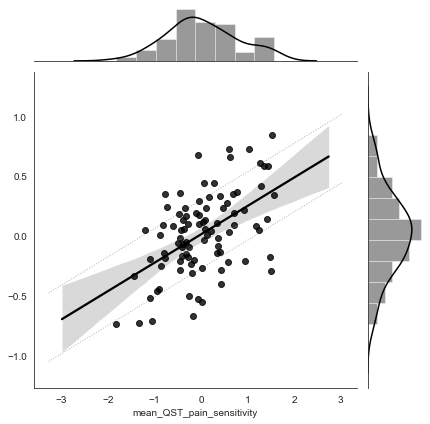

In [15]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True, covar=[])

### Save the nested-cv predictions

In [16]:
# save nested predictions
np.savetxt("../res/multi-center/nested_cv_combat_pred_full_GroupKFold30.csv", predicted, delimiter=",")